# Example 11 : Time series SRA using FDM

Time series analysis to acceleration transfer functions and spectral ratios.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pystrata

%matplotlib inline

In [ ]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Load time series data

In [ ]:
fname = "data/NIS090.AT2"
with open(fname) as fp:
    next(fp)
    description = next(fp).strip()
    next(fp)
    parts = next(fp).split()
    time_step = float(parts[1])

    accels = [float(part) for line in fp for part in line.split()]

    ts = pystrata.motion.TimeSeriesMotion(fname, description, time_step, accels)

In [ ]:
ts.accels

array([2.33833e-07, 2.99033e-07, 5.15835e-07, ..., 4.90601e-05,
       4.94028e-05, 4.96963e-05])

There are a few supported file formats. AT2 files can be loaded as follows:

In [ ]:
ts = pystrata.motion.TimeSeriesMotion.load_at2_file(fname)
ts.accels

array([2.33833e-07, 2.99033e-07, 5.15835e-07, ..., 4.90601e-05,
       4.94028e-05, 4.96963e-05])

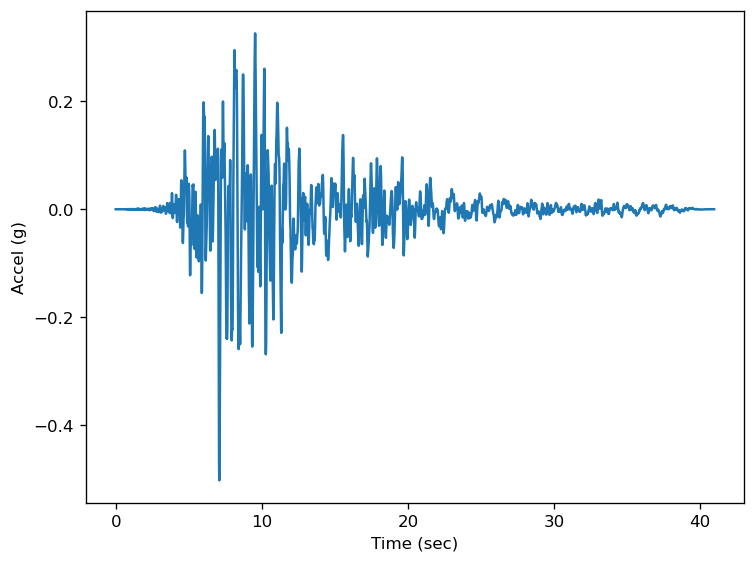

In [ ]:
fig, ax = plt.subplots()
ax.plot(ts.times, ts.accels)
ax.set(xlabel="Time (sec)", ylabel="Accel (g)")
fig.tight_layout();

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [ ]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            30,
            400,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [ ]:
calcs = [
    ("EQL", pystrata.propagation.EquivalentLinearCalculator()),
    (
        "FDM (KA)",
        pystrata.propagation.FrequencyDependentEqlCalculator(strain_ratio=0.65, method='ka02'),
    ),
    (
        "FDM (ZR)",
        pystrata.propagation.FrequencyDependentEqlCalculator(method='zr15'),
    ),
    (
        "FDM (KO 0.3)",
        pystrata.propagation.FrequencyDependentEqlCalculator(method='ko:20'),
    ),
]

## Specify the output

In [ ]:
freqs = np.logspace(-1, np.log10(50.0), num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
        ),
        pystrata.output.AccelTransferFunctionOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            ko_bandwidth=30,
        ),
    ]
)

## Perform the calculation

Compute the response of the site, and store the state within the calculation object, which is then used along with the output collection to compute the desired outputs. Also, extract the computed properties for comparison.

In [ ]:
properties = {}
for name, calc in calcs:
    calc(ts, profile, profile.location("outcrop", index=-1))
    outputs(calc, name)

    properties[name] = {
        key: getattr(profile[0], key) for key in ["shear_mod_reduc", "damping"]
    }

## Plot the final properties

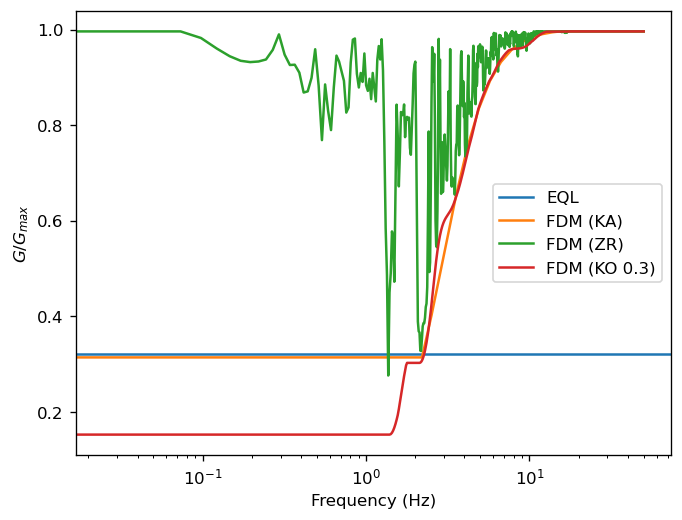

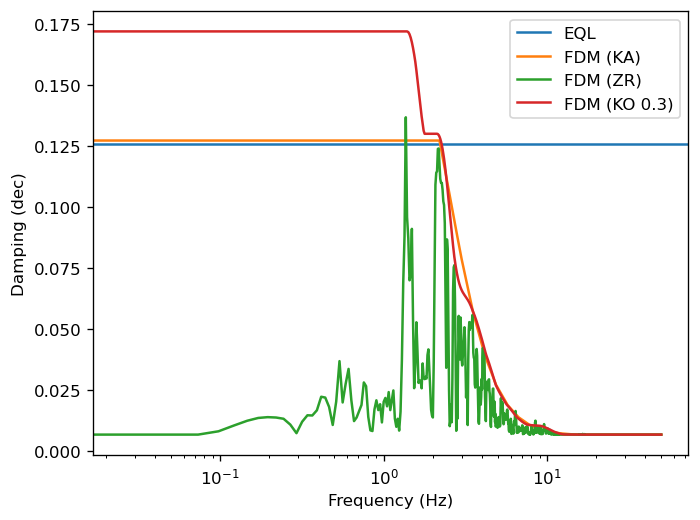

In [ ]:
for key in properties["EQL"].keys():
    fig, ax = plt.subplots()

    for i, (k, p) in enumerate(properties.items()):
        if k == "EQL":
            ax.axhline(p[key], label=k, color=f"C{i}")
        else:
            ax.plot(ts.freqs, p[key], label=k, color=f"C{i}")

    ax.set(
        ylabel={"damping": "Damping (dec)", "shear_mod_reduc": r"$G/G_{max}$"}[key],
        xlabel="Frequency (Hz)",
        xscale="log",
    )
    ax.legend()

## Plot the outputs

Create a few plots of the output.

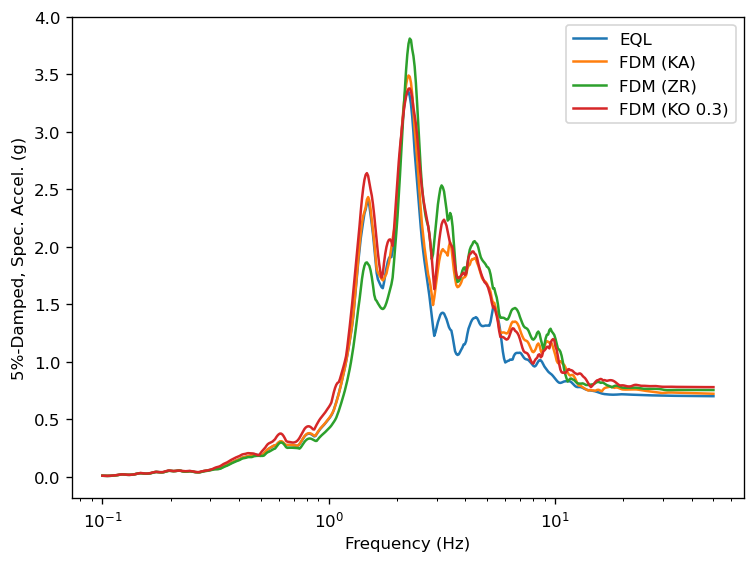

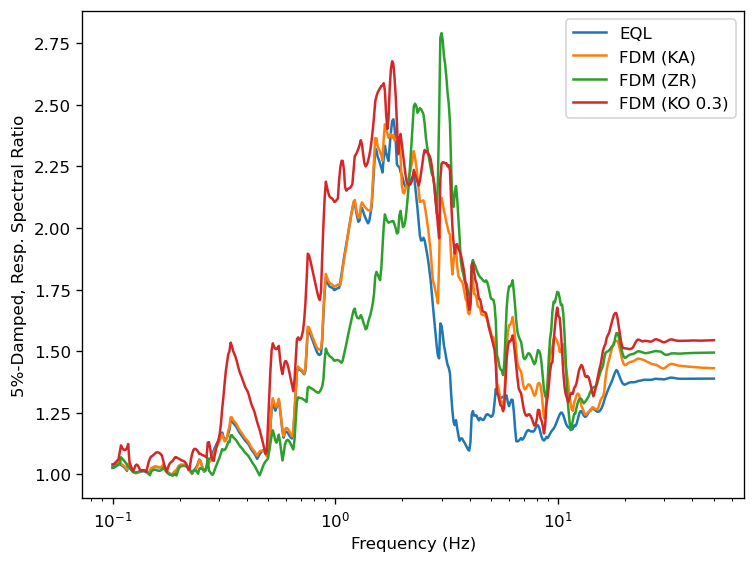

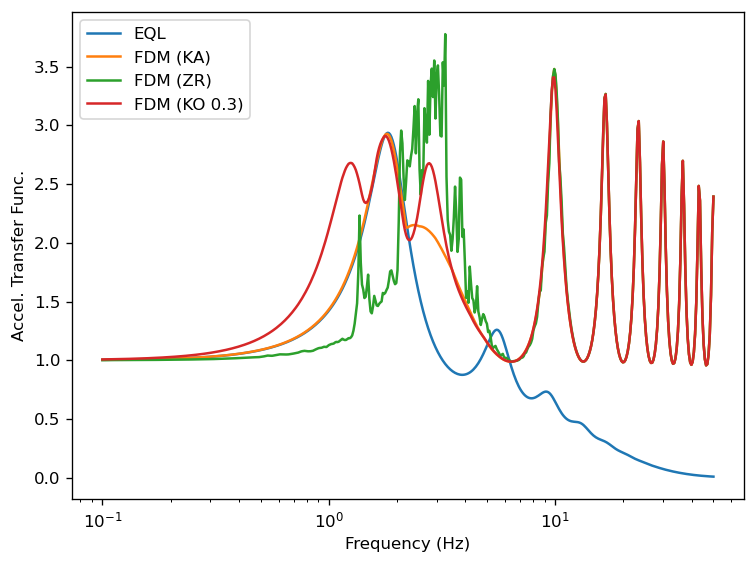

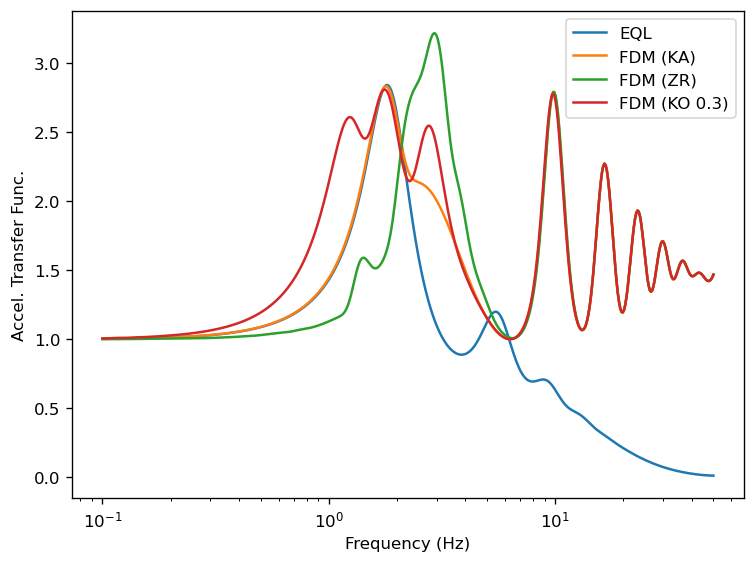

In [ ]:
for output in outputs:
    fig, ax = plt.subplots()
    for name, refs, values in output.iter_results():
        ax.plot(refs, values, label=name)

    ax.set(xlabel=output.xlabel, xscale="log", ylabel=output.ylabel)
    ax.legend()
    fig.tight_layout()